## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import time
from random import random

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
PATH = './cifar_net.pth'

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [3]:
from model import *
from data import *
from pre_processing import *

In [4]:
batch_size = 1024 * 6
dataset = Loader(batch_size=batch_size)
trainloader = dataset.trainloader

def examples(trainloader):
    # get some random training images
    dataiter = iter(trainloader)
    images, _ = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images[:4]))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


print('Examples:')
# examples(trainloader)

Wait for both datasets to be downloaded and verified.
Files already downloaded and verified
Files already downloaded and verified
Examples:


## Autoencoder

An autoencoder is a type of neural network that finds the function mapping the features x to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: (1) an encoder learns the data representation in lower-dimension space, i.e. extracting the most salient features of the data, and (2) a decoder learns to reconstruct the original data based on the learned representation by the encoder.

We define our autoencoder class with fully connected layers for both its encoder and decoder components.

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate an `AE` object.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [5]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
net = AE().to(device)
print('Network:', net)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

Network:AE(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 6, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
  )
)


We train our autoencoder for our specified number of epochs.

In [6]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

print("start training")

# # to train loaded network further
# net = AE()
# net.load_state_dict(torch.load(PATH))
# net.to(device)

def transformTensor(tensor, epoch):
    # if epoch < 25:
    #     return tensor
    images = np.copy(tensor.data.numpy())
    noise_images = add_gaussian_noise(images, 0, 0.0003 * epoch)
    tensor = torch.from_numpy(noise_images)
    return tensor.to(device, dtype=torch.float)

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = transformTensor(img, epoch).to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        timePerEpoch = (time.time() - start_time)/(epoch + 1)
        left = timePerEpoch * (NUM_EPOCHS - epoch + 1)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, NUM_EPOCHS, loss), ' aprox. ' + str(round(left / 60)) + ' min left')
 
    print('Finished Training')
    elapsed_time = time.time() - start_time
    print('final duration: ' + str(round(elapsed_time / 60)) + 'min')
    return train_loss

loss = train(net, dataset.trainloader, 120)
torch.save(net.state_dict(), PATH) 

start training
Epoch 1 of 120, Train Loss: 0.255 aprox. 47 min left
Epoch 2 of 120, Train Loss: 0.238 aprox. 45 min left
Epoch 3 of 120, Train Loss: 0.224 aprox. 45 min left
Epoch 4 of 120, Train Loss: 0.213 aprox. 44 min left
Epoch 5 of 120, Train Loss: 0.201 aprox. 44 min left
Epoch 6 of 120, Train Loss: 0.192 aprox. 43 min left
Epoch 7 of 120, Train Loss: 0.187 aprox. 43 min left
Epoch 8 of 120, Train Loss: 0.182 aprox. 42 min left
Epoch 9 of 120, Train Loss: 0.179 aprox. 42 min left
Epoch 10 of 120, Train Loss: 0.176 aprox. 42 min left
Epoch 11 of 120, Train Loss: 0.179 aprox. 41 min left
Epoch 12 of 120, Train Loss: 0.175 aprox. 41 min left
Epoch 13 of 120, Train Loss: 0.174 aprox. 40 min left
Epoch 14 of 120, Train Loss: 0.173 aprox. 40 min left
Epoch 15 of 120, Train Loss: 0.171 aprox. 40 min left
Epoch 16 of 120, Train Loss: 0.170 aprox. 39 min left
Epoch 17 of 120, Train Loss: 0.170 aprox. 39 min left
Epoch 18 of 120, Train Loss: 0.169 aprox. 38 min left
Epoch 19 of 120, Train

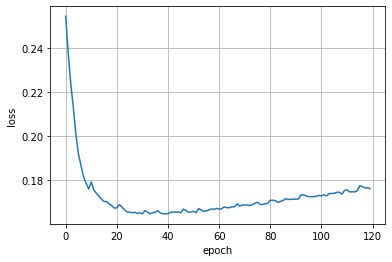

In [7]:
"""
*******************************************************
****** skip this step if you dont want to train *******
*******************************************************
"""

fig, ax = plt.subplots()
ax.plot(loss)
ax.set(xlabel='epoch', ylabel='loss')
ax.grid()
plt.draw()

1:


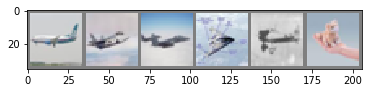

2:


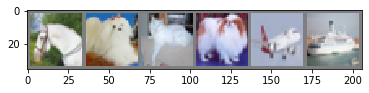

3:


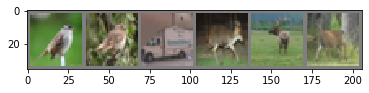

4:


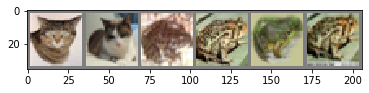

5:


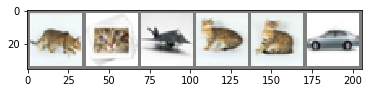

6:


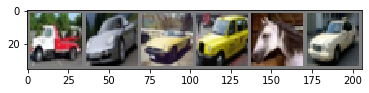

7:


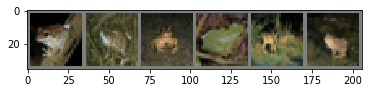

8:


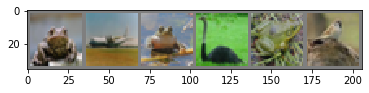

9:


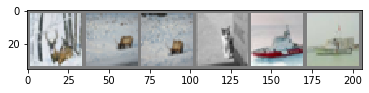

10:


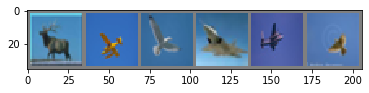

11:


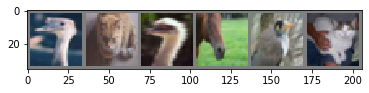

12:


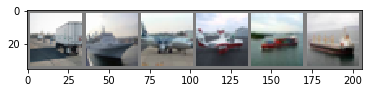

13:


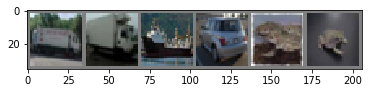

14:


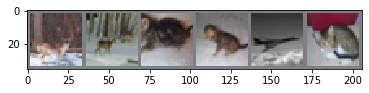

15:


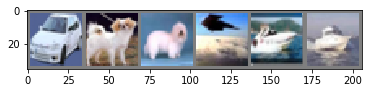

16:


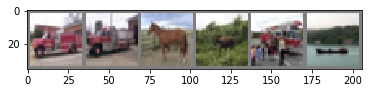

17:


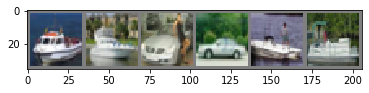

18:


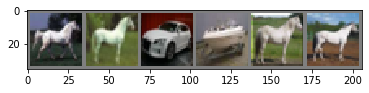

19:


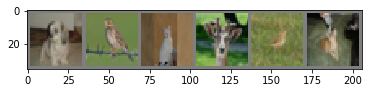

20:


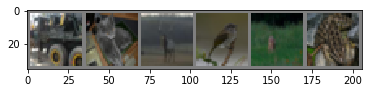

In [8]:
from eval import *
# load test set
dataset_iter = iter(dataset.testloader)
images, _ = dataset_iter.next()
length = len(images)

# load network
net2 = AE()
net2.load_state_dict(torch.load(PATH))

# model should output latent space and not reconstruction
net2.getLatentSpace(True)

# process images
outputs = net2(images).data.numpy()
outputShape = np.shape(outputs)
outputs = outputs.flatten().reshape(length, np.prod(outputShape[1:]))

# get 20 closest image sets
for i in range(20):
    closest = findNClosest(outputs[round(random() * length)], outputs, 6)
    closeImages = []
    for img in closest:
        closeImages.append(images[int(img[-1])])
    print(i+1, ':')
    imshow(torchvision.utils.make_grid(closeImages))